In [1]:
# Install MySql packages
# conda update -n base -c conda-forge conda --yes
# !pip install ipython-sql
# !pip install mysql-connector-python
# !conda install -c conda-forge python-dotenv --yes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import mysql.connector
from mysql.connector import Error
from os import environ, path
from dotenv import load_dotenv
from pandas.api.types import CategoricalDtype

In [3]:
# Read enviromental variables to connect the database
load_dotenv()
password = environ.get('PASSWORD')
host = environ.get('HOST')
database = environ.get('DATABASE')

In [4]:
# List of colors
colors = ['lime', 'darkorange', 'darkgreen', 'royalblue', 
         'darkred', 'gold', 'teal', 'blueviolet', 'coral', 
         'yellowgreen', 'steelblue', 'crimson', 'tan']

## Connect to the database and create dataframes for each table

In [5]:
try:
    connection = mysql.connector.connect(host=host ,
                                        database=database,
                                        user='root',
                                        password=password)
    if connection.is_connected():
        print("Succes Connected")
    df_musician = pd.read_sql_query("SELECT * FROM music_and_death.musician;", connection)
    df_birth = pd.read_sql_query("SELECT * FROM music_and_death.birth;", connection)
    df_death = pd.read_sql_query("SELECT * FROM music_and_death.death;", connection)
    df_genre = pd.read_sql_query("SELECT * FROM music_and_death.music_genre;", connection)
    genre = pd.read_sql_query("SELECT * FROM music_and_death.genre;", connection)
    cause_death = pd.read_sql_query("SELECT * FROM music_and_death.cause_death;", connection)
    cities = pd.read_sql_query("SELECT * FROM music_and_death.cities;", connection)
    states = pd.read_sql_query("SELECT * FROM music_and_death.states;", connection)
    countries = pd.read_sql_query("SELECT * FROM music_and_death.countries;", connection)
    
    
except Error as e:
    print("Error closing connection")

# Concatenate tables
else:
    # Concatenate musician and death dataframes
    df = pd.concat([df_musician, df_birth], axis=1)
    df = pd.concat([df, df_death], axis=1)
    df = pd.merge(df, cause_death, on=["death_id", "death_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, df_genre, on=["musician_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, genre, on=["genre_id"])
    # rearrange columns
    df = df.iloc[:, [0, 1, 2, 3, 5, 7, 8, 9, 11, 6, 4, 10]]
    
finally:
    connection.close()

Succes Connected


## Merge and clean the cities, states and countries tables

In [6]:
# merge cities table with states table
place = cities.merge(states, 
                      left_on=cities["state_id"], 
                      right_on=states["id"])

# drop duplicate keys
place.drop(['key_0', 'state_id', 'id_y'], axis=1, inplace=True)

# merge resulted table with countries table
place = place.merge(countries, 
                        left_on=place["country_id"],
                        right_on=countries["id"])

# drop duplicated keys
place.drop(['key_0', 'country_id', 'id', 'iso2', 'capital'], 
              axis=1, 
              inplace=True)

# rename column names
place.rename(
    columns={'name_x': 'City', 
             'name_y': 'State', 
             'name': 'Country', 
             'id_x': 'city_id'},
    inplace=True
)

##  Drop columns with not use

In [7]:
df.drop(['middle_name', 'death_id', "death_date", "genre_id", "birth"], 
        axis=1, 
        inplace=True)

In [8]:
df

,musician_id,stage_name,stage_lastname,death_age,cause,genre,birthplace_id
0,1,John,Lennon,40,homicide,rock,50337
1,432,Kit,Lambert,45,homicide,rock,50388
2,459,Rusty,Day,36,homicide,rock,117057
3,481,Felix,Pappalardi,43,homicide,rock,122795
4,2,Kurt,Cobain,27,suicide,rock,110979
...,...,...,...,...,...,...,...
530,380,Sara,Carter,80,unknown,country,125539
531,525,Hammie,Nixon,76,unknown,country,112931
532,516,Meredith,Willson,82,heart disease,classical,121375
533,478,William,Walton,80,natural,classical,50807


In [9]:
place

,city_id,City,State,Country
0,52,Ashkāsham,Badakhshan,Afghanistan
1,68,Fayzabad,Badakhshan,Afghanistan
2,78,Jurm,Badakhshan,Afghanistan
3,84,Khandūd,Badakhshan,Afghanistan
4,115,Rāghistān,Badakhshan,Afghanistan
...,...,...,...,...
148261,131496,Redcliff,Midlands Province,Zimbabwe
148262,131502,Shangani,Midlands Province,Zimbabwe
148263,131503,Shurugwi,Midlands Province,Zimbabwe
148264,131504,Shurugwi District,Midlands Province,Zimbabwe


## Merge musician info dataframe with place dataframe

In [10]:
# merge df and place dataframes
musician = df.merge(place, 
                    left_on=df['birthplace_id'], 
                    right_on=place['city_id'])

# drop unused columns
musician.drop(['birthplace_id', 'city_id', 'key_0'], axis=1, inplace=True)

In [11]:
musician

,musician_id,stage_name,stage_lastname,death_age,cause,genre,City,State,Country
0,1,John,Lennon,40,homicide,rock,Liverpool,England,United Kingdom
1,271,Rory,Storm,34,suicide,rock,Liverpool,England,United Kingdom
2,502,Tom,Evans,36,suicide,rock,Liverpool,England,United Kingdom
3,473,Billy,Fury,42,heart disease,rock,Liverpool,England,United Kingdom
4,188,Brian,Epstein,32,drug overdose,rock,Liverpool,England,United Kingdom
...,...,...,...,...,...,...,...,...,...
529,380,Sara,Carter,80,unknown,country,Russell County,Virginia,United States
530,525,Hammie,Nixon,76,unknown,country,Brownsville,Tennessee,United States
531,516,Meredith,Willson,82,heart disease,classical,Mason City,Iowa,United States
532,478,William,Walton,80,natural,classical,Oldham,England,United Kingdom


## Create plots to observe the data

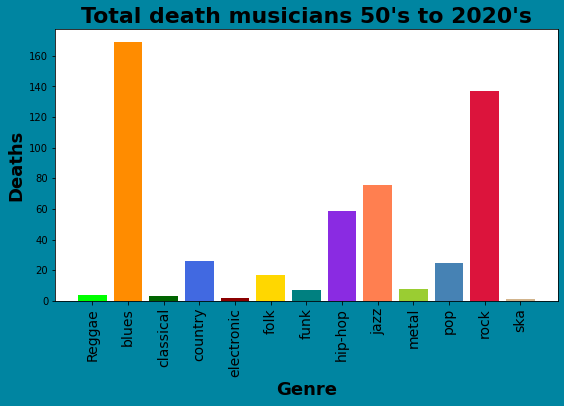

In [12]:
# Bar plot to show deaths per music genre 

# Create a new music table using genre as indez and size of each genre
df_n = musician.pivot_table(index=['genre'], aggfunc='size')

# plot the data
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor("white")
ax.set_title("Total death musicians 50's to 2020's",
             size=22,
             fontweight="bold" )
plt.bar(df_n.index, df_n, color=colors)
plt.ylabel("Deaths", size=18, fontweight="bold")
plt.xlabel("Genre", size=18, fontweight="bold")
plt.xticks(rotation='vertical', size=14)
plt.show()

## Cause of death per music genre

In [13]:
df_cd = musician.pivot_table(index=['cause', 'genre'], aggfunc='size')
df_cd

cause    genre     
AIDS     electronic     1
         pop            1
         rock           2
Burned   blues          1
Falling  rock           1
                       ..
unknown  electronic     1
         folk           2
         jazz          11
         pop            3
         rock           3
Length: 99, dtype: int64

# Questions

## Most common Death Ages


In [14]:
n_da = musician['death_age'].value_counts().nlargest(10)

In [15]:
n_da

27    26
32    24
37    17
28    17
34    15
36    15
39    14
33    14
24    14
25    14
Name: death_age, dtype: int64

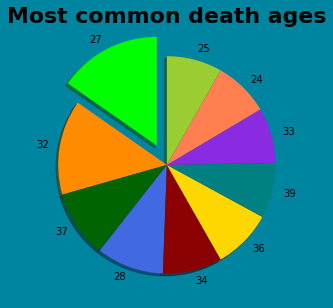

In [16]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Most common death ages",
             size=22,
             fontweight="bold" )
plt.pie(n_da.values, labels=n_da.index, 
        colors=colors,
        startangle=90,
        shadow=True,
        explode = [0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
plt.show()

## Most common Music Genre deaths

In [17]:
n_mg = musician['genre'].value_counts()

In [18]:
n_mg

blues         169
rock          137
jazz           76
hip-hop        59
country        26
pop            25
folk           17
metal           8
funk            7
Reggae          4
classical       3
electronic      2
ska             1
Name: genre, dtype: int64

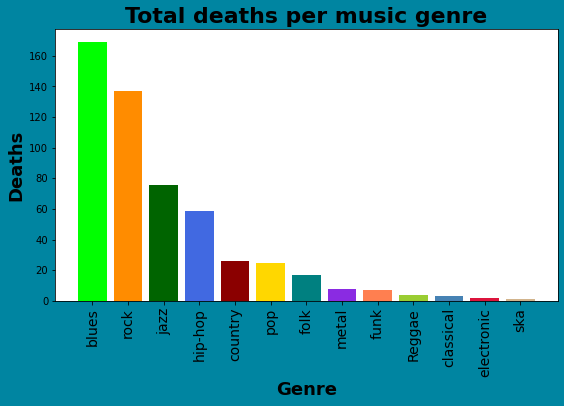

In [19]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Total deaths per music genre",
             size=22,
             fontweight="bold" )
plt.bar(n_mg.index, n_mg.values, color=colors)
plt.ylabel("Deaths", size=18, fontweight="bold")
plt.xlabel("Genre", size=18, fontweight="bold")
plt.xticks(rotation='vertical', size=14)
plt.show()

# Places

### Most common countries of origin of dead musicians

In [20]:
n_places = musician['Country'].value_counts().nlargest(10)

In [21]:
n_places

United States     431
United Kingdom     55
Canada              6
Jamaica             6
Australia           5
Germany             4
South Africa        2
New Zealand         2
Lithuania           2
Spain               2
Name: Country, dtype: int64

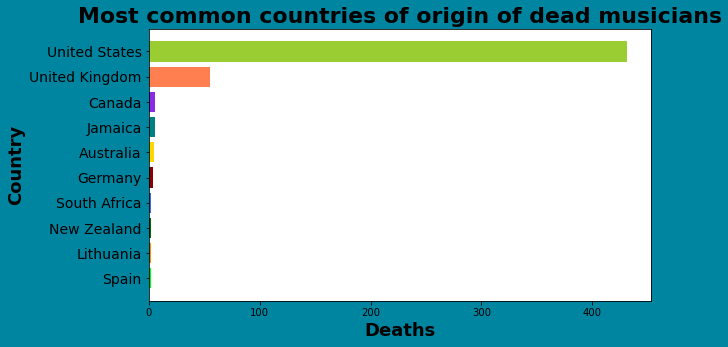

In [22]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Most common countries of origin of dead musicians",
            size=22,
            fontweight="bold")
plt.barh(n_places.iloc[::-1].index, n_places.iloc[::-1].values, color=colors)
plt.ylabel("Country", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.show()

### Most common States of origin of dead musicians

In [23]:
n_states = musician['State'].value_counts().nlargest(10)

In [24]:
n_states

Mississippi     47
New York        45
England         45
Texas           37
California      31
Louisiana       27
Tennessee       26
Georgia         18
Illinois        18
Pennsylvania    18
Name: State, dtype: int64

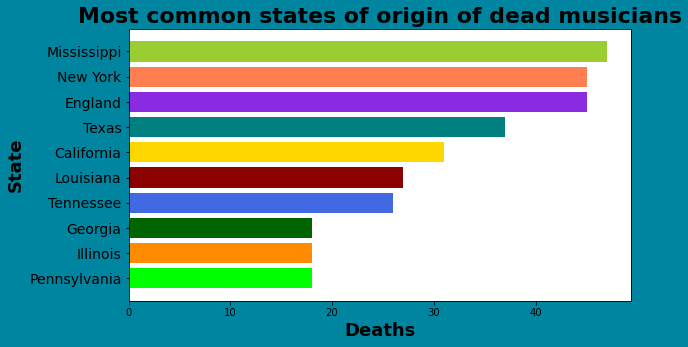

In [25]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Most common states of origin of dead musicians",
            size=22,
            fontweight="bold")
plt.barh(n_states.iloc[::-1].index, n_states.iloc[::-1].values, color=colors)
plt.ylabel("State", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.show()

### Most common Cities

In [26]:
n_cities = musician['City'].value_counts().nlargest(10)

In [27]:
n_cities

New York City       27
London              17
Chicago             16
Philadelphia        14
Los Angeles         12
New Orleans         12
Memphis             11
Birmingham          10
Detroit              6
Washington, D.C.     5
Name: City, dtype: int64

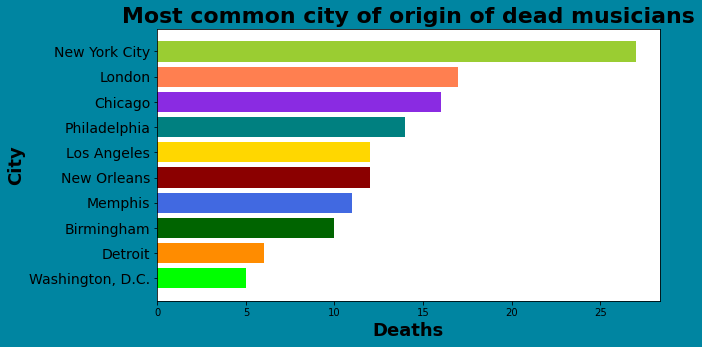

In [28]:
plt.figure(figsize=(9, 5), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Most common city of origin of dead musicians",
            size=22,
            fontweight="bold")
plt.barh(n_cities.iloc[::-1].index, n_cities.iloc[::-1].values, color=colors)
plt.ylabel("City", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.show()

## Death genre - cause

In [29]:
n_cd_gr = musician.loc[:, ['genre', 'cause']].value_counts()

In [30]:
n_cd_gr.head(10)

genre    cause                  
hip-hop  homicide                   58
blues    heart disease              50
rock     drug overdose              24
jazz     heart disease              23
blues    unknown                    23
         cancer                     23
rock     heart disease              22
         suicide                    18
         car/motorcycle accident    17
jazz     cancer                     13
dtype: int64

In [31]:
n_cd_gr = n_cd_gr.reset_index()
n_cd_gr.rename(columns={0: 'deaths'}, inplace=True)

In [32]:
n_cd_gr

,genre,cause,deaths
0,hip-hop,homicide,58
1,blues,heart disease,50
2,rock,drug overdose,24
3,jazz,heart disease,23
4,blues,unknown,23
...,...,...,...
94,pop,cancer,1
95,folk,brain related,1
96,pop,drawning,1
97,jazz,aircraft accident,1


### Blues 

In [33]:
n_blues = n_cd_gr.loc[n_cd_gr['genre'] == 'blues', ]

In [34]:
n_blues

,genre,cause,deaths
1,blues,heart disease,50
4,blues,unknown,23
5,blues,cancer,23
10,blues,homicide,12
12,blues,respiratory disease,11
17,blues,brain related,7
20,blues,diabetes,6
21,blues,alcohol related,6
23,blues,car/motorcycle accident,6
24,blues,drug overdose,6


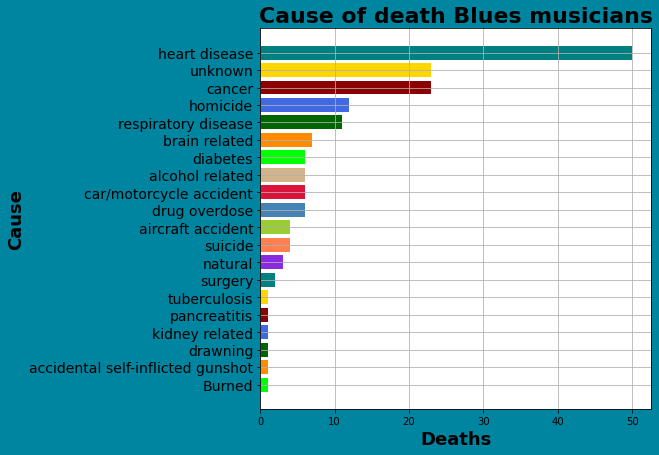

In [56]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Cause of death Blues musicians",
            size=22,
            fontweight="bold")
plt.barh(n_blues['cause'].iloc[::-1],
         n_blues['deaths'].iloc[::-1],
         color=colors)
plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()


### Rock

In [36]:
n_rock = n_cd_gr.loc[n_cd_gr['genre'] == 'rock', ]

In [37]:
n_rock

,genre,cause,deaths
2,rock,drug overdose,24
6,rock,heart disease,22
7,rock,suicide,18
8,rock,car/motorcycle accident,17
11,rock,alcohol related,12
13,rock,cancer,11
19,rock,aircraft accident,6
27,rock,brain related,5
28,rock,drawning,5
29,rock,respiratory disease,4


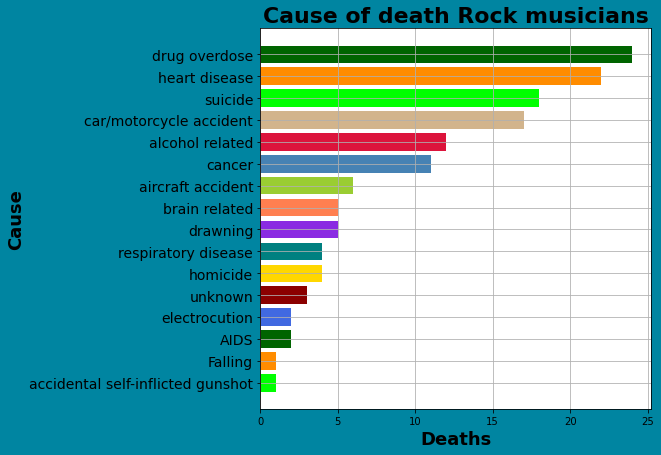

In [58]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Cause of death Rock musicians",
            size=22,
            fontweight="bold")
plt.barh(n_rock['cause'].iloc[::-1],
         n_rock['deaths'].iloc[::-1],
         color=colors)

plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()


## Most common Cause o deaths

In [59]:
n_cause_death = musician['cause'].value_counts().nlargest(10)

In [60]:
n_cause_death

heart disease              114
homicide                    82
cancer                      56
drug overdose               47
unknown                     46
car/motorcycle accident     37
suicide                     28
aircraft accident           23
respiratory disease         23
alcohol related             20
Name: cause, dtype: int64

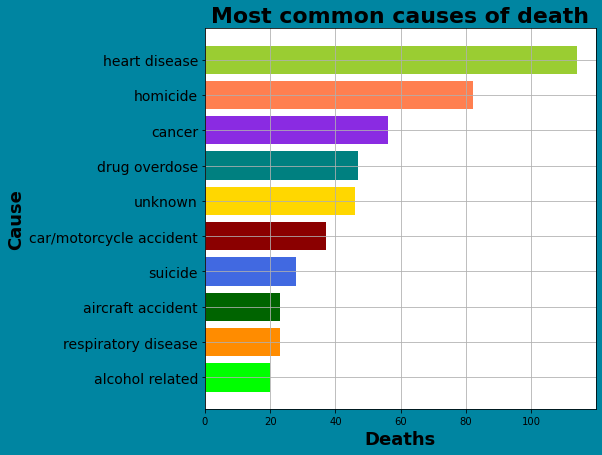

In [62]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Most common causes of death",
            size=22,
            fontweight="bold")
plt.barh(n_cause_death.iloc[::-1].index,
         n_cause_death.iloc[::-1].values,
         color=colors)

plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()
